In [1]:
import numpy as np
from scipy.signal import hilbert, find_peaks
import matplotlib.pyplot as plt
import os
from scipy.io import wavfile
from scipy import signal
from scipy.ndimage import gaussian_filter1d
from IPython.display import display, clear_output
import ipywidgets as widgets
from IPython.display import HTML
import pandas as pd
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
import random  # Importamos random para el ruido

In [2]:
 samplerate, data_sonido = wavfile.read('/home/felipe/Documents/Proyectos doctorado/horneros/audios/audios_sintesis/H19-031020041016_recorte.wav')


#HA061020041409-solo_hembra_recorte.wav

In [30]:
############################################
# NUEVA FORMA DE GENERAR LA SEÑAL DE PRESION
############################################


# Define the period of the function
period = 4000

# Asumiendo que data_sonido y samplerate están definidos anteriormente
# Create a time vector with integer multiples of 1/samplerate
time = np.arange(len(data_sonido)) / samplerate

# 1. Calcular la envolvente
senal_analitica = hilbert(data_sonido)
envolvente = np.abs(senal_analitica)
envolvente_suavizada = np.convolve(envolvente, np.ones(700)/700, mode='same')  # Suavizado inicial

# 2. Detectar picos iniciales
peaks_iniciales, _ = find_peaks(
    envolvente_suavizada,
    distance=int(samplerate * 0.08),
    height=1.2 * np.mean(envolvente)
)

class ReviewerPicos:
    def __init__(self, time, envolvente_suavizada, peaks_iniciales):
        self.time = time
        self.envolvente_suavizada = envolvente_suavizada
        self.peaks_iniciales = peaks_iniciales
        self.peaks_ajustados = []
        self.pico_actual = 0
        self.env_normalizada = envolvente_suavizada / np.max(envolvente_suavizada)

        # Widgets
        self.output = widgets.Output()
        self.info_text = widgets.HTML(value="")
        self.desplazamiento_input = widgets.FloatText(
            value=0.0,
            description='Desplazar (s):',
            style={'description_width': 'initial'}
        )

        # Botones
        self.btn_aceptar = widgets.Button(
            description='✓ Aceptar',
            button_style='success',
            tooltip='Confirmar este pico'
        )
        self.btn_omitir = widgets.Button(
            description='✗ Omitir',
            button_style='danger',
            tooltip='Saltar este pico'
        )
        self.btn_desplazar = widgets.Button(
            description='→ Desplazar',
            button_style='warning',
            tooltip='Mover el pico la cantidad especificada'
        )
        self.btn_agregar = widgets.Button(
            description='+ Agregar pico',
            button_style='info',
            tooltip='Agregar un nuevo pico'
        )
        self.btn_finalizar = widgets.Button(
            description='🏁 Finalizar',
            button_style='primary',
            tooltip='Terminar y generar resultado'
        )

        # Agregar pico manual
        self.tiempo_nuevo_input = widgets.FloatText(
            value=0.0,
            description='Tiempo (s):',
            style={'description_width': 'initial'}
        )

        # Conectar eventos
        self.btn_aceptar.on_click(self.aceptar_pico)
        self.btn_omitir.on_click(self.omitir_pico)
        self.btn_desplazar.on_click(self.desplazar_pico)
        self.btn_agregar.on_click(self.agregar_pico)
        self.btn_finalizar.on_click(self.finalizar)

        # Layout inicial
        self.setup_interface()
        self.mostrar_pico_actual()

    def setup_interface(self):
        # Información inicial
        info_inicial = f"""
        <h3>🎯 Detector de Picos Interactivo</h3>
        <p><strong>Se detectaron {len(self.peaks_iniciales)} picos inicialmente.</strong></p>
        <p>Para cada pico puedes:</p>
        <ul>
            <li><span style="color:green">✓ Aceptar:</span> Confirmar que el pico está bien posicionado</li>
            <li><span style="color:red">✗ Omitir:</span> Eliminar este pico</li>
            <li><span style="color:orange">→ Desplazar:</span> Mover el pico un tiempo específico (+ adelante, - atrás)</li>
        </ul>
        <hr>
        """
        self.info_text.value = info_inicial

        # Controles principales
        controles_pico = widgets.HBox([
            self.btn_aceptar,
            self.btn_omitir,
            self.desplazamiento_input,
            self.btn_desplazar
        ])

        # Controles adicionales
        controles_extra = widgets.HBox([
            self.tiempo_nuevo_input,
            self.btn_agregar,
            widgets.HTML("&nbsp;&nbsp;&nbsp;"),
            self.btn_finalizar
        ])

        # Layout completo
        self.interface = widgets.VBox([
            self.info_text,
            controles_pico,
            controles_extra,
            self.output
        ])

        display(self.interface)

    def mostrar_pico_actual(self):
        with self.output:
            clear_output(wait=True)

            if self.pico_actual >= len(self.peaks_iniciales):
                self.mostrar_resumen()
                return

            peak_idx = self.peaks_iniciales[self.pico_actual]

            # Crear figura
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

            # Plot detallado (zoom)
            ventana = int(samplerate * 0.5)
            inicio = max(0, peak_idx - ventana)
            fin = min(len(self.time), peak_idx + ventana)

            ax1.plot(self.time[inicio:fin], self.env_normalizada[inicio:fin],
                    'b-', alpha=0.7, label='Envolvente')
            ax1.axvline(x=self.time[peak_idx], color='r', linestyle='--',
                       alpha=0.8, label=f'Pico {self.pico_actual+1}')
            ax1.scatter(self.time[peak_idx], self.env_normalizada[peak_idx],
                       color='red', s=100, zorder=5)
            ax1.set_xlabel('Tiempo (s)')
            ax1.set_ylabel('Amplitud normalizada')
            ax1.set_title(f'PICO {self.pico_actual+1}/{len(self.peaks_iniciales)} - Tiempo: {self.time[peak_idx]:.3f}s')
            ax1.legend()
            ax1.grid(True, alpha=0.3)

            # Plot general
            ax2.plot(self.time, self.env_normalizada, 'b-', alpha=0.3, label='Envolvente completa')

            # Picos confirmados
            if self.peaks_ajustados:
                ax2.scatter(self.time[self.peaks_ajustados], self.env_normalizada[self.peaks_ajustados],
                           color='green', s=50, alpha=0.7, label=f'Confirmados ({len(self.peaks_ajustados)})')

            # Pico actual
            ax2.axvline(x=self.time[peak_idx], color='r', linestyle='--', alpha=0.8)
            ax2.scatter(self.time[peak_idx], self.env_normalizada[peak_idx], color='red', s=100, zorder=5)

            # Picos restantes
            picos_restantes = self.peaks_iniciales[self.pico_actual+1:]
            if len(picos_restantes) > 0:
                ax2.scatter(self.time[picos_restantes], self.env_normalizada[picos_restantes],
                           color='orange', s=30, alpha=0.5, label=f'Pendientes ({len(picos_restantes)})')

            ax2.set_xlabel('Tiempo (s)')
            ax2.set_ylabel('Amplitud normalizada')
            ax2.set_title('Vista general - Progreso de revisión')
            ax2.legend()
            ax2.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()

            # Actualizar info
            peak_time = self.time[peak_idx]
            info_actual = f"""
            <div style="background-color: #f0f0f0; padding: 10px; border-radius: 5px; margin: 10px 0;">
                <h4>📍 Revisando Pico {self.pico_actual+1} de {len(self.peaks_iniciales)}</h4>
                <p><strong>Tiempo actual:</strong> {peak_time:.3f} segundos</p>
                <p><strong>Progreso:</strong> {len(self.peaks_ajustados)} confirmados, {len(self.peaks_iniciales) - self.pico_actual - 1} pendientes</p>
            </div>
            """

        # Actualizar info fuera del output para evitar conflictos
        original_info = self.info_text.value.split('<hr>')[0] + '<hr>'
        self.info_text.value = original_info + info_actual

    def aceptar_pico(self, b):
        peak_idx = self.peaks_iniciales[self.pico_actual]
        self.peaks_ajustados.append(peak_idx)
        self.pico_actual += 1
        self.mostrar_pico_actual()

    def omitir_pico(self, b):
        self.pico_actual += 1
        self.mostrar_pico_actual()

    def desplazar_pico(self, b):
        if self.pico_actual >= len(self.peaks_iniciales):
            return

        desplazamiento = self.desplazamiento_input.value
        peak_idx = self.peaks_iniciales[self.pico_actual]
        nuevo_tiempo = self.time[peak_idx] + desplazamiento

        # Encontrar índice más cercano
        nuevo_idx = np.argmin(np.abs(self.time - nuevo_tiempo))

        if 0 <= nuevo_idx < len(self.time):
            self.peaks_iniciales[self.pico_actual] = nuevo_idx
            self.desplazamiento_input.value = 0.0  # Reset
            self.mostrar_pico_actual()
        else:
            with self.output:
                print("❌ Desplazamiento fuera de rango")

    def agregar_pico(self, b):
        tiempo_nuevo = self.tiempo_nuevo_input.value
        nuevo_idx = np.argmin(np.abs(self.time - tiempo_nuevo))

        if 0 <= nuevo_idx < len(self.time):
            self.peaks_ajustados.append(nuevo_idx)
            self.tiempo_nuevo_input.value = 0.0  # Reset

            with self.output:
                clear_output(wait=True)
                print(f"✓ Nuevo pico agregado en t={self.time[nuevo_idx]:.3f}s")

                # Mostrar confirmación visual
                plt.figure(figsize=(10, 4))
                plt.plot(self.time, self.env_normalizada, 'b-', alpha=0.5)
                if self.peaks_ajustados:
                    plt.scatter(self.time[self.peaks_ajustados], self.env_normalizada[self.peaks_ajustados],
                               color='green', s=80, label='Todos los picos confirmados')
                plt.axvline(x=self.time[nuevo_idx], color='r', linestyle='--', alpha=0.8)
                plt.xlabel('Tiempo (s)')
                plt.ylabel('Amplitud')
                plt.title('Nuevo pico agregado')
                plt.legend()
                plt.grid(True, alpha=0.3)
                plt.show()
        else:
            with self.output:
                print("❌ Tiempo fuera de rango")

    def mostrar_resumen(self):
        info_final = f"""
        <div style="background-color: #e8f5e8; padding: 15px; border-radius: 10px; margin: 10px 0;">
            <h3>✅ ¡Revisión de picos completada!</h3>
            <p><strong>Picos confirmados:</strong> {len(self.peaks_ajustados)}</p>
            <p>Presiona <strong>"🏁 Finalizar"</strong> para generar el resultado final.</p>
        </div>
        """

        with self.output:
            clear_output(wait=True)
            if len(self.peaks_ajustados) > 0:
                plt.figure(figsize=(12, 6))
                plt.plot(self.time, self.env_normalizada, 'b-', alpha=0.5, label='Envolvente')
                plt.scatter(self.time[sorted(self.peaks_ajustados)],
                           self.env_normalizada[sorted(self.peaks_ajustados)],
                           color='green', s=100, zorder=5, label=f'Picos confirmados ({len(self.peaks_ajustados)})')
                plt.xlabel('Tiempo (s)')
                plt.ylabel('Amplitud')
                plt.title('Resumen - Todos los picos confirmados')
                plt.legend()
                plt.grid(True, alpha=0.3)
                plt.show()
            else:
                print("⚠️ No se confirmaron picos.")

        original_info = self.info_text.value.split('<hr>')[0] + '<hr>'
        self.info_text.value = original_info + info_final

    def finalizar(self, b):
        # Ordenar picos
        peaks_finales = sorted(self.peaks_ajustados)

        with self.output:
            clear_output(wait=True)

            if len(peaks_finales) > 0:
                # Generar función final
                z_aux = campanas_seno_suavizado(self.time, self.time[peaks_finales])
                z = z_aux / np.max(z_aux) if np.max(z_aux) > 0 else z_aux

                # Gráfico final
                plt.figure(figsize=(14, 7))
                plt.plot(self.time, self.env_normalizada, 'b-', alpha=0.5, label='Envolvente (normalizada)')
                plt.plot(self.time, z, 'purple', alpha=0.8, linewidth=2, label='Pulsos suaves con seno (FINAL)')
                plt.scatter(self.time[peaks_finales], self.env_normalizada[peaks_finales],
                           color='green', s=100, zorder=5, label='Picos confirmados')

                plt.xlabel('Tiempo (s)')
                plt.ylabel('Amplitud')
                plt.title('🎉 RESULTADO FINAL - Pulsos suaves con coseno')
                plt.legend()
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.show()

                print("🎉 ¡Proceso completado exitosamente!")
                print(f"📊 Se generó la función con {len(peaks_finales)} picos confirmados.")

                # Hacer disponibles las variables finales
                globals()['peaks_finales'] = np.array(peaks_finales)
                globals()['z_final'] = z
                print("📝 Variables disponibles: 'peaks_finales', 'z_final'")

            else:
                print("⚠️ No se confirmaron picos. No se generará función.")

def campanas_seno_suavizado(t, puntos, k=500, delta_factor=0.5):
    t = np.array(t)
    resultado = np.zeros_like(t, dtype=float)

    for j in range(0, len(puntos), 2):
        t_ini = puntos[j]
        t_fin = puntos[j+1]
        dur = t_fin - t_ini
        if dur <= 0:
            continue

        delta = delta_factor * dur
        t_ini_ext = t_ini - delta
        t_fin_ext = t_fin + delta
        dur_total = t_fin_ext - t_ini_ext

        mascara = (t >= t_ini_ext) & (t <= t_fin_ext)
        t_local = t[mascara]

        seno = np.sin(np.pi * (t_local - t_ini_ext) / dur_total)
        subida = 1 / (1 + np.exp(-k * (t_local - t_ini)))
        bajada = 1 / (1 + np.exp(-k * (t_local - t_fin)))
        ventana = subida * (1 - bajada)

        campana = seno * ventana
        max_val = np.max(np.abs(campana))
        if max_val > 0:
            campana /= max_val

        resultado[mascara] += campana

    return resultado

# INICIAR EL PROCESO INTERACTIVO
print("🚀 Iniciando Detector de Picos Interactivo para Google Colab...")
reviewer = ReviewerPicos(time, envolvente_suavizada, peaks_iniciales)

z=z_final

🚀 Iniciando Detector de Picos Interactivo para Google Colab...


In [31]:
z=z_final

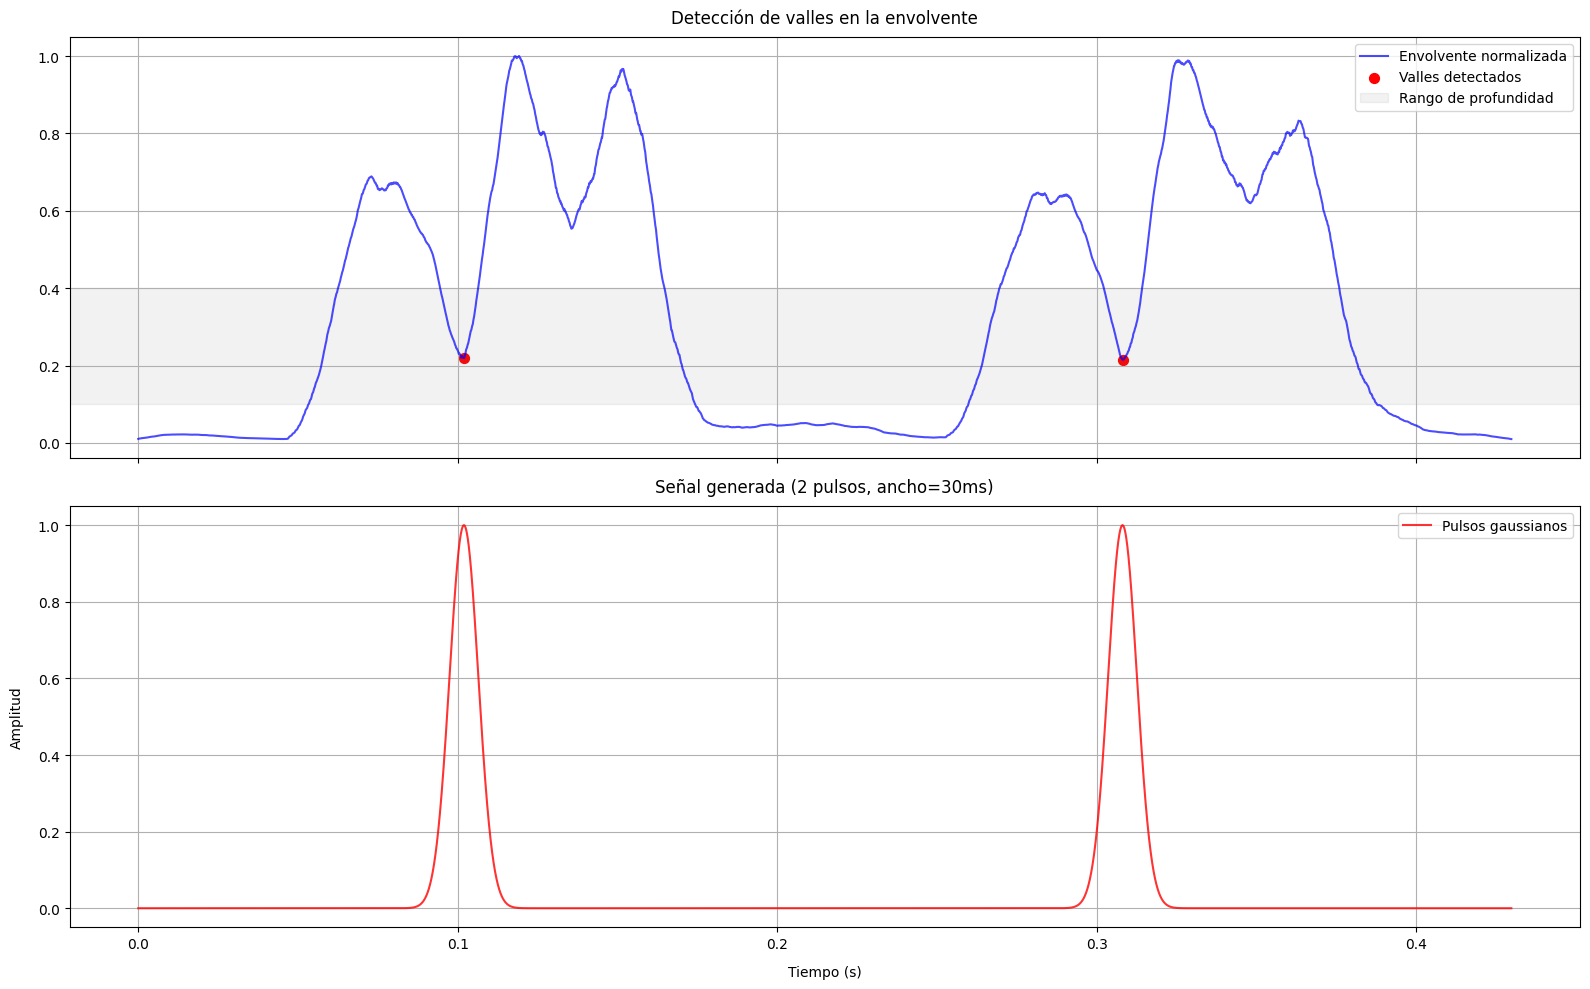

In [22]:
#####################################################
#CALCULAR LOS CORTES ---> f_0
#####################################################

# 1. Calcular envolvente mejorada (sin cambios)
def calcular_envolvente(audio, suavizado=700):
    senal_analitica = hilbert(audio)
    envolvente = np.abs(senal_analitica)
    return np.convolve(envolvente, np.ones(suavizado)/suavizado, mode='same')

envolvente_suavizada = calcular_envolvente(data_sonido, suavizado=700)

# 2. Detección de valles optimizada
def encontrar_valles(envolvente, samplerate, altura_min=0.1, altura_max=0.4, min_dist_ms=32, prominence=0.1):
    """
    Versión mejorada que:
    - Normaliza la envolvente automáticamente
    - Filtra correctamente por profundidad de valles
    - Mantiene tus parámetros originales
    """
    # Normalizar envolvente
    envolvente_norm = envolvente / np.max(envolvente)

    # Detectar todos los valles potenciales
    min_dist_muestras = int(samplerate * min_dist_ms / 1000)
    valleys, _ = find_peaks(-envolvente_norm,
                          distance=min_dist_muestras,
                          prominence=prominence)

    # Filtrar por profundidad del valle (altura original, no invertida)
    valleys_filtrados = [v for v in valleys
                        if altura_min < envolvente_norm[v] < altura_max]

    return np.array(valleys_filtrados)

# Parámetros ajustables
valleys = encontrar_valles(envolvente_suavizada, samplerate,
                         altura_min=0.1,   # Valles más profundos que 0.1 (normalizado)
                         altura_max=0.5,   # Valles menos profundos que 0.4
                         min_dist_ms=20,   # 32ms entre valles
                         prominence=0.1)   # Prominencia mínima

# 3. Generador de pulsos gaussianos
def generar_pulso_gaussiano(posicion, ancho_muestras, longitud_senal, std_dev=0.15):
    """Versión más eficiente con numpy.arange"""
    x = np.arange(longitud_senal) - posicion
    return np.exp(-(x**2)/(2*(ancho_muestras*std_dev)**2))

# Parámetros de pulsos (en segundos)
ancho_pulso_seg = 0.03  # 20ms de ancho base
ancho_pulso_muestras = int(samplerate * ancho_pulso_seg)
z_gauss = np.zeros(len(data_sonido))

for valley in valleys:
    pulso = generar_pulso_gaussiano(valley, ancho_pulso_muestras, len(data_sonido))
    z_gauss += pulso

# Normalización inteligente (preserva relación de amplitudes)
z_gauss = z_gauss / np.max(z_gauss) if np.max(z_gauss) > 0 else z_gauss

# 4. Visualización
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# Gráfico superior: Envolvente y valles
ax1.plot(time, envolvente_suavizada/np.max(envolvente_suavizada),
        'b-', alpha=0.7, label='Envolvente normalizada')
ax1.scatter(valleys/samplerate, envolvente_suavizada[valleys]/np.max(envolvente_suavizada),
           c='red', marker='o', s=50, label='Valles detectados')
ax1.axhspan(ymin=0.1, ymax=0.4, color='gray', alpha=0.1, label='Rango de profundidad')
ax1.set_title('Detección de valles en la envolvente', pad=10)
ax1.legend(loc='upper right')
ax1.grid(True)

# Gráfico inferior: Pulsos generados
ax2.plot(time, z_gauss, 'r-', linewidth=1.5, alpha=0.8, label='Pulsos gaussianos')
ax2.set_title(f'Señal generada ({len(valleys)} pulsos, ancho={ancho_pulso_seg*1000:.0f}ms)', pad=10)
ax2.set_xlabel('Tiempo (s)', labelpad=10)
ax2.set_ylabel('Amplitud', labelpad=10)
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

z_2=z_gauss #z_2 sera la funcion asociada a F_0

/tmp/ipykernel_81121/2356234148.py:9: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('/home/felipe/Documents/Proyectos doctorado/horneros/audios/audios_sintesis/pitch_19.txt', sep="   ", header=None, names=["time", "f0"], skiprows=1)  # DataFrame original


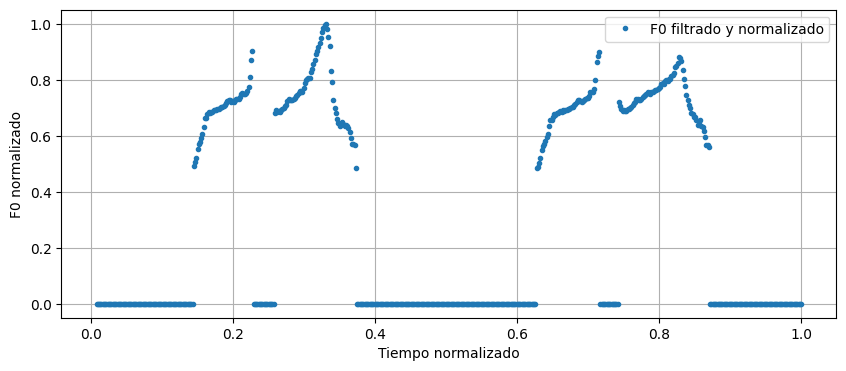

In [23]:
#####################################################
#metemos el pitch
#####################################################

import pandas as pd


# Leer el archivo .txt
df = pd.read_csv('/home/felipe/Documents/Proyectos doctorado/horneros/audios/audios_sintesis/pitch_19.txt', sep="   ", header=None, names=["time", "f0"], skiprows=1)  # DataFrame original
# info.txt es a

# Filtrar los datos (creando una copia para no modificar el original)
df_filtrado = df.copy()
df_filtrado.loc[df_filtrado['f0'] > 3500, 'f0'] = 0  # Reemplaza f0 > 8500 por 0 en la copia

# Normalizar los datos filtrados
tiempos = df_filtrado["time"] / np.max(df_filtrado["time"])  # Tiempo normalizado (0 a 1)
f_0 = df_filtrado["f0"] / np.max(df_filtrado["f0"])         # F0 normalizado (0 a 1)

# Graficar
plt.figure(figsize=(10, 4))
plt.plot(tiempos, f_0, 'o', markersize=3, label="F0 filtrado y normalizado")
plt.xlabel("Tiempo normalizado")
plt.ylabel("F0 normalizado")
plt.grid(True)
plt.legend()
plt.show()






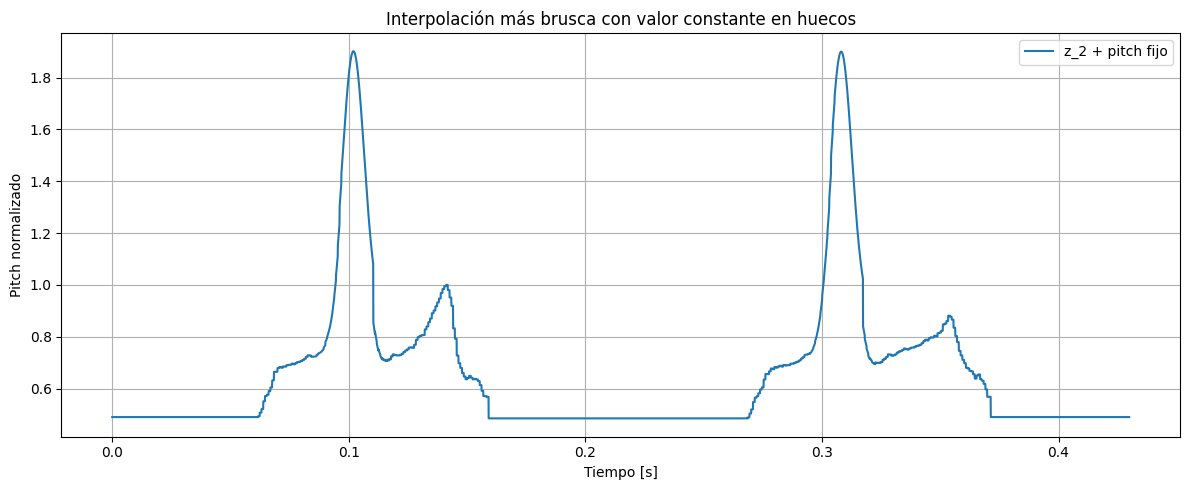

In [9]:
####################################################
# NUEVO Juntamos pitch y los cortes
#####################################################


# --- Configuraciones ---
valor_fijo = 0.49  # Valor a usar donde no hay datos

# --- 1. Datos válidos ---
tiempos_f0 = df["time"].to_numpy()
f_0 = df["f0"].to_numpy()
f_0 = f_0 / np.max(np.abs(f_0))  # Normalizar

mask_valid = f_0 > 0
tiempos_validos = tiempos_f0[mask_valid]
f_0_valid = f_0[mask_valid]

# --- 2. Definir ejes de tiempo si no está definido ---
# Asegurate de definir `time` antes de usarlo
#time = np.linspace(tiempos_f0.min(), tiempos_f0.max(), len(tiempos_f0))

# --- 3. Interpolación por pasos ---
interpolador = interp1d(
    tiempos_validos,
    f_0_valid,
    kind='previous',  # Cambiá a 'nearest' si preferís eso
    bounds_error=False,
    fill_value=np.nan
)

f_0_interpolado = interpolador(time)

# --- 4. Relleno de huecos con un valor fijo ---
mask_huecos = np.isnan(f_0_interpolado)
f_0_con_fijo = np.copy(f_0_interpolado)
f_0_con_fijo[mask_huecos] = valor_fijo

# --- 5. Combinar con z_2 ---
z_2_con_pitch = f_0_con_fijo + z_2

# --- 6. Graficar ---
plt.figure(figsize=(12, 5))
#plt.plot(tiempos_f0, f_0, 'k.', label='Pitch original (normalizado)', alpha=0.5)
#plt.plot(time, f_0_interpolado, 'r--', label='Interpolado (con huecos)', alpha=0.4)
#plt.plot(time, f_0_con_fijo, 'b-', label=f'Interpolado + valor fijo = {valor_fijo}')
plt.plot(time, z_2_con_pitch, label='z_2 + pitch fijo')
plt.xlabel('Tiempo [s]')
plt.ylabel('Pitch normalizado')
plt.title('Interpolación más brusca con valor constante en huecos')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [32]:
#####################################################
# CREAMOS RUIDO E INTEGRAMOS TODO EL MODELO CON RUIDO
#####################################################

import random  # Importamos random para el ruido

dt = 1/(2*44100.0)
tiempo_total = len(data_sonido)*dt
tiempos = np.zeros(len(data_sonido))
beta = np.zeros(len(data_sonido))
f_cero = np.zeros(len(data_sonido))
amplitud = np.zeros(len(data_sonido))
tension = np.zeros(len(data_sonido))
z = z/max(z)  # Normalización de z

global mu
global k
global c
global noise_level  # Nuevo parámetro global para el ruido

def sig(x):
    return 1/(1+np.exp(-15*((x-0.0))))

# Inicialización de parámetros
mu, k, c = 10000, 1, 0.5 #0.75
noise_level = 0.2  # ±10% de ruido 0.2

def get_k_with_noise(tension_value):
    """Función que calcula k con ruido aleatorio"""
    base_k = 0.8 * tension_value
    noise_factor = 1 + random.uniform(-noise_level, noise_level)
    return base_k * noise_factor
alpha=1
gamma = 15000 #2 * np.pi * 2000
def ecuaciones(v, dv):
    u1, v1 = v
    dv[0] = gamma * (mu*(v1-((c/mu)*u1*u1*u1-(b_temporal/mu)*u1)))
    dv[1] = -gamma * (k/mu)*(u1+alpha*u1*u1*u1+f0_temporal/k)
    return dv

# Pre-cálculo de parámetros
for i in range(len(data_sonido)):
    tiempos[i] = i*dt
    amplitud[i] = z[i]
    beta[i] = z[i]   # parámetro de presurización
    tension[i] = 0.5  # parámetro de tensión inicial
    f_cero[i] = 0.5+1.5*4.5*z_2[i]
    tension[i] = 0.3 + 1.5*z_2_con_pitch[i]## 0.5 + .4 * f_cero[i]  # actualización de tensión

# Condiciones iniciales
v = np.zeros(2)
v[0], v[1] = 0.0000, 0.0001

def rk4(dv, v, n, t, dt):
    v1 = []
    k1 = []
    k2 = []
    k3 = []
    k4 = []
    for x in range(0, n):
        v1.append(x)
        k1.append(x)
        k2.append(x)
        k3.append(x)
        k4.append(x)

    dt2 = dt/2.0
    dt6 = dt/6.0
    for x in range(0, n):
        v1[x] = v[x]
    dv(v1, k1)
    for x in range(0, n):
        v1[x] = v[x]+dt2*k1[x]
    dv(v1, k2)
    for x in range(0, n):
        v1[x] = v[x]+dt2*k2[x]
    dv(v1, k3)
    for x in range(0, n):
        v1[x] = v[x]+dt*k3[x]
    dv(v1, k4)
    for x in range(0, n):
        v1[x] = v[x]+dt*k4[x]
    for x in range(0, n):
        v[x] = v[x]+dt6*(2.0*(k2[x]+k3[x])+k1[x]+k4[x])
    return v

n = 2  # Cantidad de variables
x1 = []
y1 = []
tiempo1 = []
sonido = [] # Asegúrate de que esta lista esté vacía para el nuevo cálculo
cont1 = 0

# Simulación principal con ruido
for i in range(int(tiempo_total/(dt))):
    # Estas variables deben ser globales o pasarse a ecuaciones
    # para que ecuaciones las pueda usar. La forma actual de tu código
    # asume que son globales debido a que son reasignadas en el bucle principal.
    # Python lo permite, pero es mejor práctica pasarlas como argumentos.
    b_temporal = 1.5*beta[i]
    f0_temporal = 1.1*f_cero[i]
    k = get_k_with_noise(tension[i])  # Aquí aplicamos el ruido
    t = i*dt

    # Ejecutar un paso de Runge-Kutta 4
    rk4(ecuaciones, v, n, t, dt)

    # Almacenamiento de resultados
    # Asegúrate de que 'append' se use para agregar elementos,
    # y la asignación directa 'x1[cont1] = ...' se usa para modificar elementos
    # que ya existen. Como las listas están vacías al inicio, necesitamos 'append'.
    x1.append(v[0]) # u actual
    y1.append(v[1]) # v actual
    tiempo1.append(t)

    # *** INICIO DE LA ALTERACIÓN INDISPENSABLE ***
    # Calcula la derivada de u (dv[0] en la función ecuaciones) usando los valores actualizados de u y v
    u_val = v[0] # Es el valor de u (o x1) en el instante actual después del RK4
    v_val = v[1] # Es el valor de v (o y1) en el instante actual después del RK4

    # La expresión para du/dt es: gamma * (mu*(v1-((c/mu)*u1*u1*u1-(b_temporal/mu)*u1)))
    # Sustituyendo u1 por u_val y v1 por v_val:
    du_dt_valor = gamma * (mu * (v_val - ((c/mu) * u_val**3 - (b_temporal/mu) * u_val)))
    
    # Añadimos este valor a la lista de sonido
    sonido.append(du_dt_valor)
    # *** FIN DE LA ALTERACIÓN INDISPENSABLE ***
    
    cont1 = cont1+1

# NOTA: Después del bucle, probablemente querrás normalizar 'sonido' antes de usarlo
# para generar un archivo de audio o para graficarlo.
# Ejemplo de normalización:
# sonido = np.array(sonido)
# if len(sonido) > 0:
#     sonido_normalizado = sonido / np.max(np.abs(sonido))
# else:
#     sonido_normalizado = sonido
# Ahora usa 'sonido_normalizado'

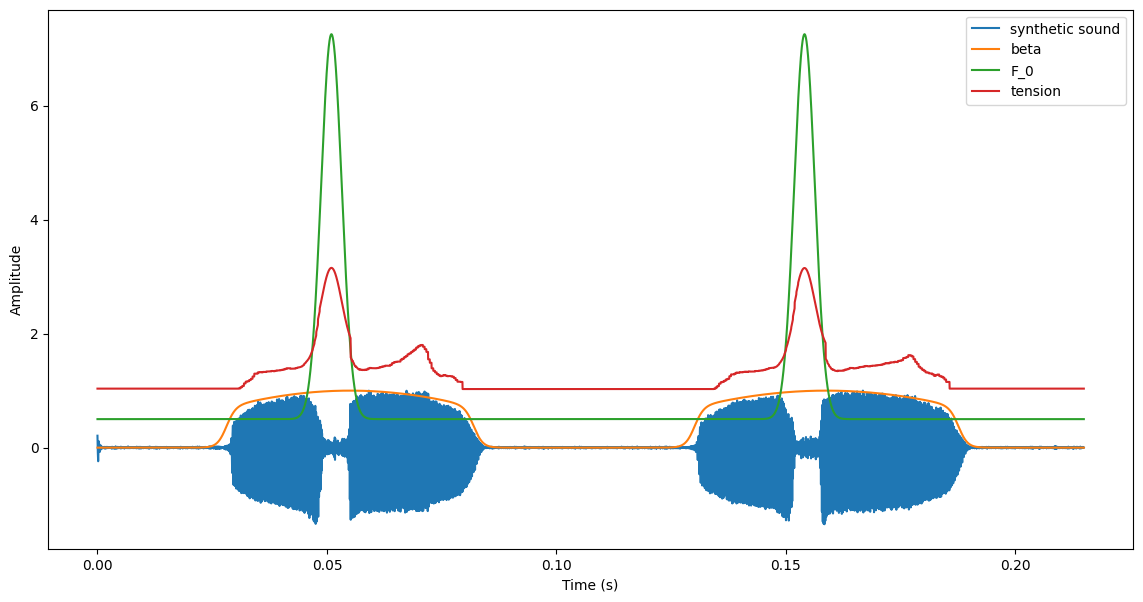

In [33]:
#####################################################
# GRAFICAMOS
#####################################################

plt.figure(figsize=(14,7))
sonido = np.asarray(sonido)/np.max(np.asarray(sonido))
plt.plot(tiempo1,sonido, label='synthetic sound')
plt.plot(tiempo1,beta, label='beta')
plt.plot(tiempo1,f_cero, label='F_0')
plt.plot(tiempo1, tension, label='tension')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
#plt.plot(tiempo1[:10000],actividad[:10000])
#plt.plot(tiempo1,inestabilidad)

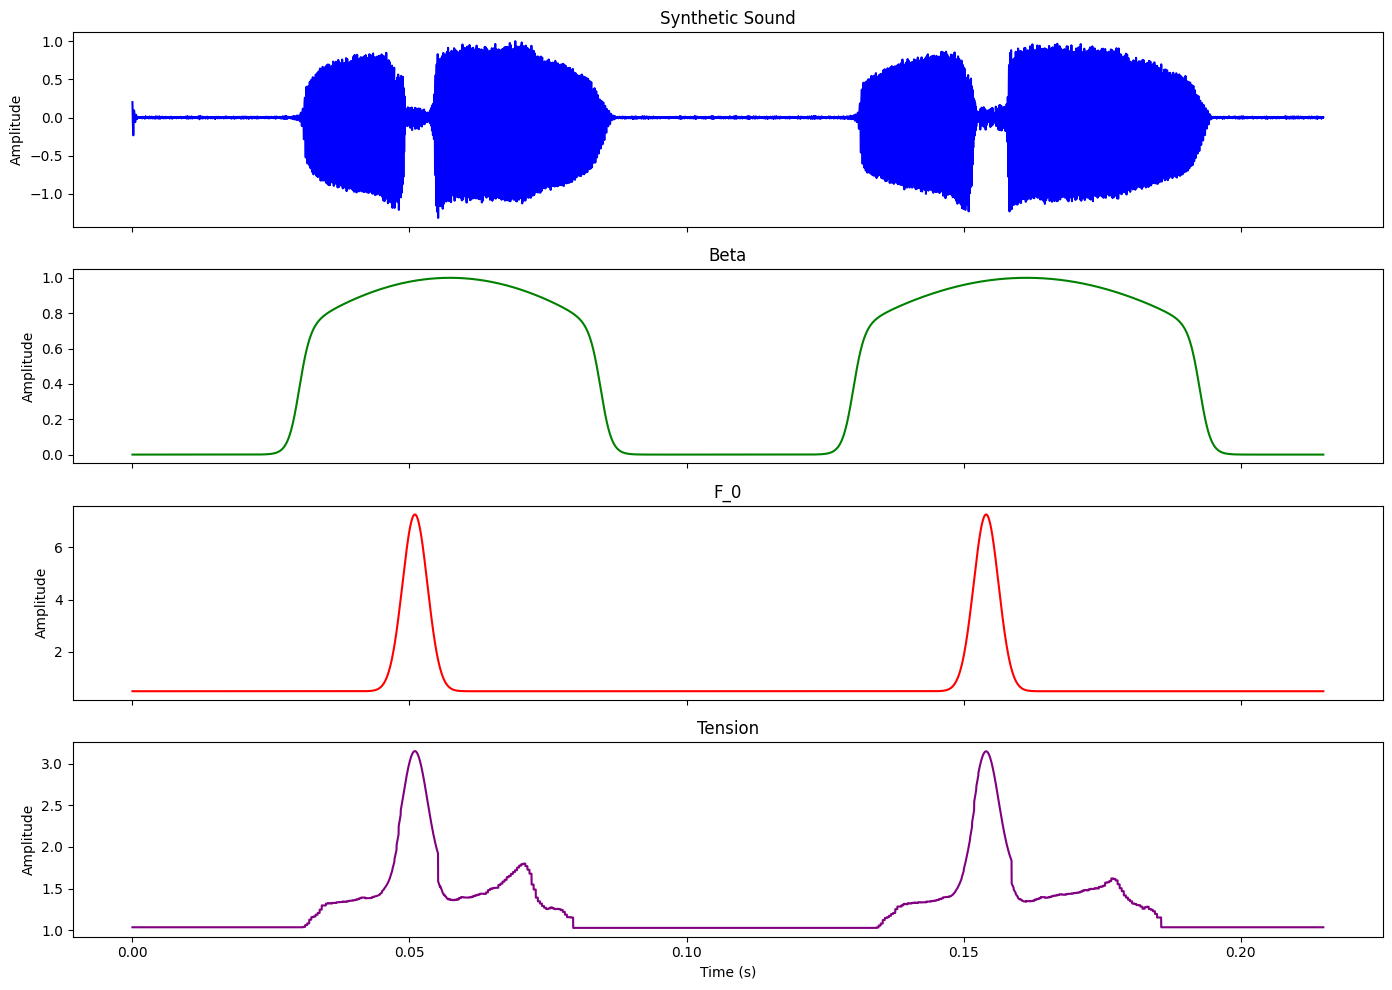

In [12]:
#####################################################
# GRAFICAMOS
#####################################################

# Crear la figura con subplots verticales (4 filas, 1 columna)
fig, axs = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

# Configurar espaciado entre subplots
plt.subplots_adjust(hspace=0.3)

# Subplot 1: sonido
axs[0].plot(tiempo1[:50000], sonido[:50000], 'b-')
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Synthetic Sound')

# Subplot 2: beta
axs[1].plot(tiempo1[:50000], beta[:50000], 'g-')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('Beta')

# Subplot 3: f_cero
axs[2].plot(tiempo1[:50000], f_cero[:50000], 'r-')
axs[2].set_ylabel('Amplitude')
axs[2].set_title('F_0')

# Subplot 4: tension
axs[3].plot(tiempo1[:50000], tension[:50000], 'purple')
axs[3].set_ylabel('Amplitude')
axs[3].set_title('Tension')

# Configurar etiqueta x solo en el subplot inferior
axs[3].set_xlabel('Time (s)')

# Ajustar la disposición para optimizar espacio
plt.tight_layout()

# Mostrar la figura
plt.show()

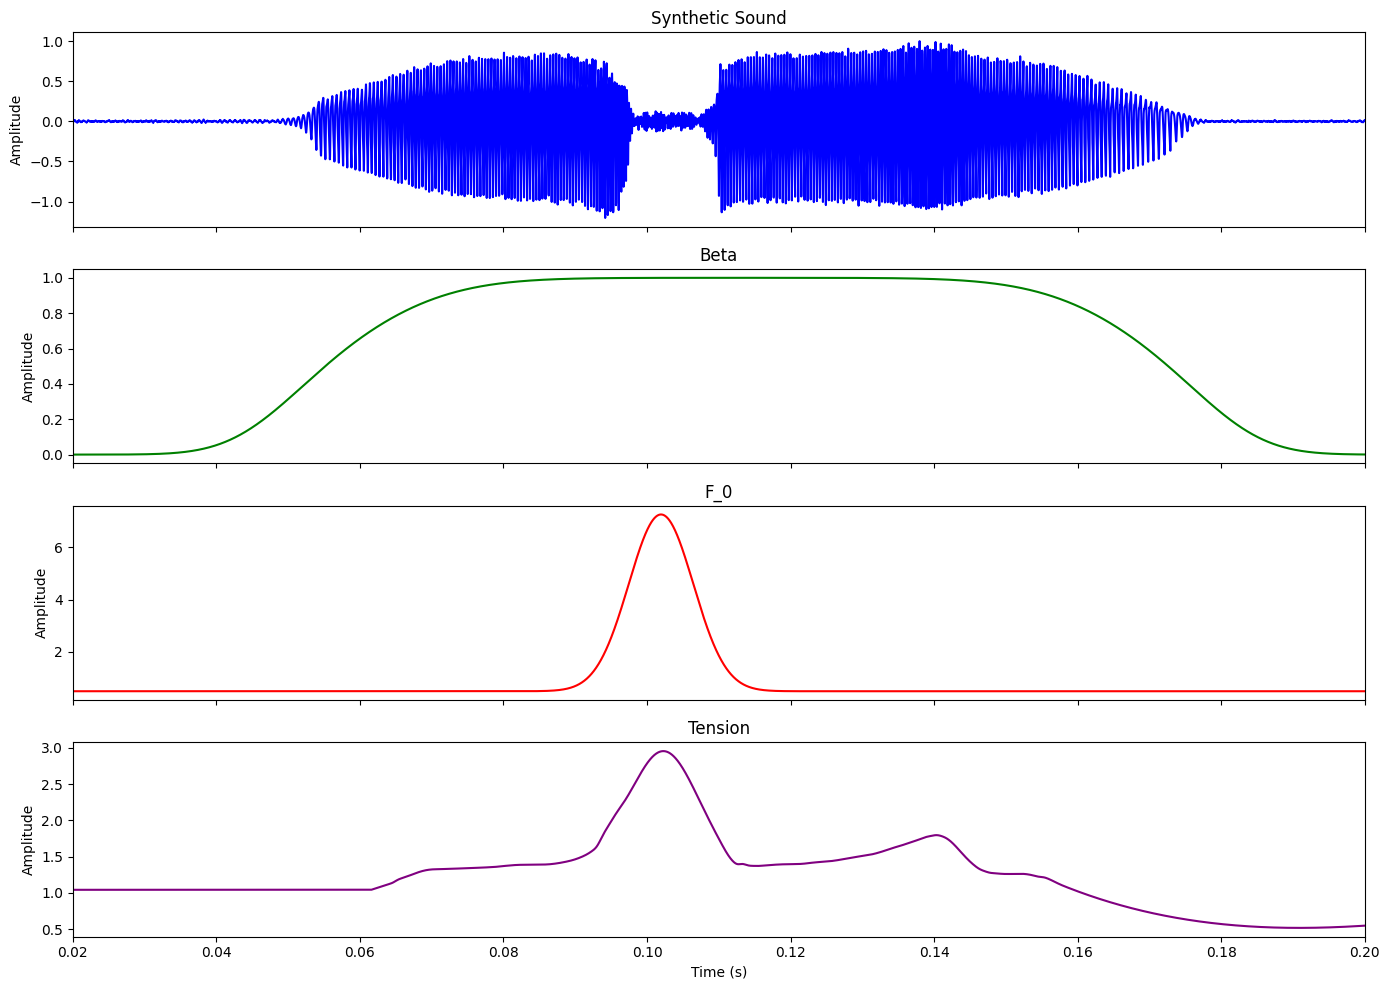

In [10]:
#####################################################
# GRAFICAMOS
#####################################################

# Crear la figura con subplots verticales (4 filas, 1 columna)
fig, axs = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

# Configurar espaciado entre subplots
plt.subplots_adjust(hspace=0.3)

# Subplot 1: sonido
axs[0].plot(tiempo1[:50000], sonido[:50000], 'b-')
axs[0].set_xlim(0, 0.28 / 2)
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Synthetic Sound')
axs[0].set_xlim(0.025/2, 0.2/2)
# Subplot 2: beta
axs[1].plot(tiempo1[:50000], beta[:50000], 'g-')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('Beta')

# Subplot 3: f_cero
axs[2].plot(tiempo1[:50000], f_cero[:50000], 'r-')
axs[2].set_ylabel('Amplitude')
axs[2].set_title('F_0')

# Subplot 4: tension
axs[3].plot(tiempo1[:50000], tension[:50000], 'purple')
axs[3].set_ylabel('Amplitude')
axs[3].set_title('Tension')

# Configurar etiqueta x solo en el subplot inferior
axs[3].set_xlabel('Time (s)')

# Configurar etiqueta x solo en el subplot inferior
axs[3].set_xlabel('Time (s)')

# Multiplicar por 2 las etiquetas del eje X (sin cambiar los datos)
xticks = axs[3].get_xticks()
axs[3].set_xticks(xticks)
axs[3].set_xticklabels([f"{x * 2:.2f}" for x in xticks])


# Ajustar la disposición para optimizar espacio
plt.tight_layout()
plt.savefig("/home/felipe/Documents/Proyectos doctorado/horneros/figuras_sintesis/parametros_19", format='pdf', dpi=300)

# Mostrar la figura
plt.show()

In [36]:
#####################################################
# GUARDAMOS EL AUDIO
#####################################################


# prompt: save sonido as a wav file, sampled at 44.1 kHz. save it into the same folder I read the data from

import soundfile as sf
sf.write('/home/felipe/Documents/Proyectos doctorado/horneros/audios/audios_sintesis/audios_nuevos/19_sintesis_19.wav', sonido, 44100)

# Guardar los datos interpolados en un archivo .txt
datos_interpolados = np.column_stack((tiempo_comun, beta_interp, f_cero_interp, tension_interp))
np.savetxt(
    "/home/felipe/Documents/Proyectos doctorado/horneros/figuras_sintesis/parametros_19.txt",
    datos_interpolados,
    header="tiempo_comun\tbeta\tf_cero\ttension",
    fmt="%.6f",  # 6 decimales
    delimiter="\t"
)




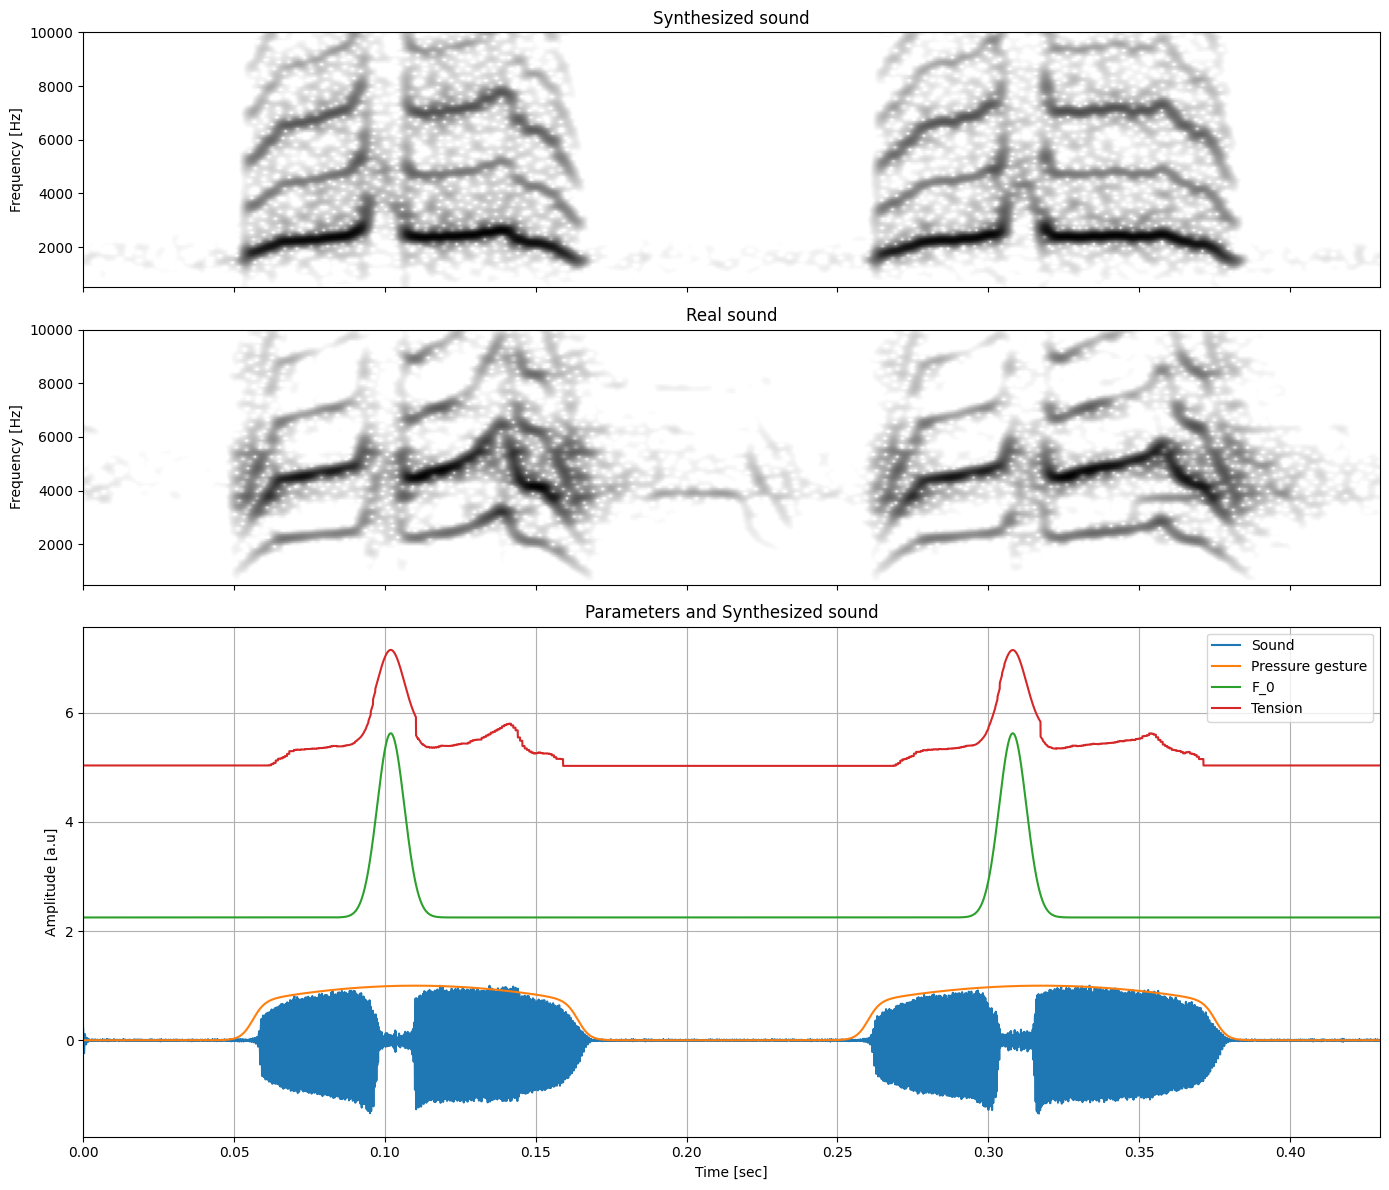

In [34]:
#Tiempos en comun

sonido = np.asarray(sonido)
sonido_filtrado = sonido
sonido = sonido / max(sonido)
fs = 44100  # frecuencia de muestreo en Hz
t = np.arange(len(sonido)) / fs

from scipy import signal, interpolate

# Tiempo común basado en la señal de sonido
tiempo_comun = np.linspace(min(t), max(t), len(sonido))

# Interpolación de parámetros al eje temporal común
interp_beta = interpolate.interp1d(np.linspace(min(t), max(t), len(beta)), beta, kind='linear', fill_value="extrapolate")
interp_f_0 = interpolate.interp1d(np.linspace(min(t), max(t), len(f_cero)), f_cero, kind='linear', fill_value="extrapolate")
interp_tension = interpolate.interp1d(np.linspace(min(t), max(t), len(tension)), tension, kind='linear', fill_value="extrapolate")

beta_interp = interp_beta(tiempo_comun)
f_cero_interp = interp_f_0(tiempo_comun)
tension_interp = interp_tension(tiempo_comun)

# Detectar regiones activas (transiciones arriba y abajo del umbral)
umbral = 0.9
activo = sonido > umbral
cambios = np.diff(activo.astype(int))
inicios = np.where(cambios == 1)[0]
finales = np.where(cambios == -1)[0]

# Asegurar pares consistentes
if finales.size and inicios.size:
    if finales[0] < inicios[0]:
        finales = finales[1:]
    if inicios[-1] > finales[-1]:
        inicios = inicios[:-1]

# Convertir índices a tiempos en segundos
tiempos_inicios = t[inicios]
tiempos_finales = t[finales]

# Crear array intercalado [t_inicio_1, t_final_1, t_inicio_2, t_final_2, ...]
tiempos_inicio_final = np.empty(tiempos_inicios.size + tiempos_finales.size, dtype=tiempos_inicios.dtype)
tiempos_inicio_final[0::2] = tiempos_inicios
tiempos_inicio_final[1::2] = tiempos_finales



# Crear subgráficos
fig, ax = plt.subplots(
    3, 1, figsize=(14, 12), sharex=True,
    gridspec_kw={'height_ratios': [1, 1, 2]}
)

# Espectrograma 1 (real)
f1, t_spec1, Sxx1 = signal.spectrogram(
    sonido_filtrado, fs=44100, window=('gaussian', 64),
    nperseg=512, noverlap=510, scaling='spectrum'
)
Sxx1 = np.clip(Sxx1, a_min=np.amax(Sxx1) / 10**5, a_max=np.amax(Sxx1))
extent1 = [tiempo_comun[0], tiempo_comun[-1], f1[0], f1[-1]]
ax[0].imshow(np.log10(Sxx1), aspect='auto', origin='lower',
             extent=extent1, cmap='Greys', rasterized=True)
ax[0].set_ylim(500, 10000)
ax[0].set_ylabel('Frequency [Hz]')
ax[0].set_title('Synthesized sound')

# Espectrograma 2 (sintético)
f2, t_spec2, Sxx2 = signal.spectrogram(
    data_sonido, fs=44100, window=('gaussian', 64),
    nperseg=512, noverlap=510, scaling='spectrum'
)
Sxx2 = np.clip(Sxx2, a_min=np.amax(Sxx2) / 10**5, a_max=np.amax(Sxx2))
extent2 = [tiempo_comun[0], tiempo_comun[-1], f2[0], f2[-1]]
ax[1].imshow(np.log10(Sxx2), aspect='auto', origin='lower',
             extent=extent2, cmap='Greys', rasterized=True)
ax[1].set_ylim(500, 10000)
ax[1].set_ylabel('Frequency [Hz]')
ax[1].set_title('Real sound')

# Envolvente y parámetros
ax[2].plot(tiempo_comun, sonido, label='Sound')
ax[2].plot(tiempo_comun, beta_interp, label='Pressure gesture')
ax[2].plot(tiempo_comun, f_cero_interp / 2 + 2, label='F_0')
ax[2].plot(tiempo_comun, tension_interp + 4, label='Tension')
ax[2].set_ylabel('Amplitude [a.u]')
ax[2].set_xlabel('Time [sec]')
ax[2].set_title('Parameters and Synthesized sound')


#for t_line in tiempos_inicio_final:
 #   ax[0].axvline(x=t_line, color='red', linestyle='--', alpha=0.7, linewidth=1)
  #  ax[1].axvline(x=t_line, color='red', linestyle='--', alpha=0.7, linewidth=1)
   # ax[2].axvline(x=t_line, color='red', linestyle='--', alpha=0.7, linewidth=1)

# Limitar tiempo
ax[0].set_xlim(tiempo_comun[0], tiempo_comun[-1])

# Ajustes finales
plt.tight_layout()
ax[2].legend()
plt.grid(True)
#plt.savefig("/home/felipe/Documents/Proyectos doctorado/horneros/figuras_sintesis/espect_param_2_A_2", format='pdf', dpi=300)

plt.show()




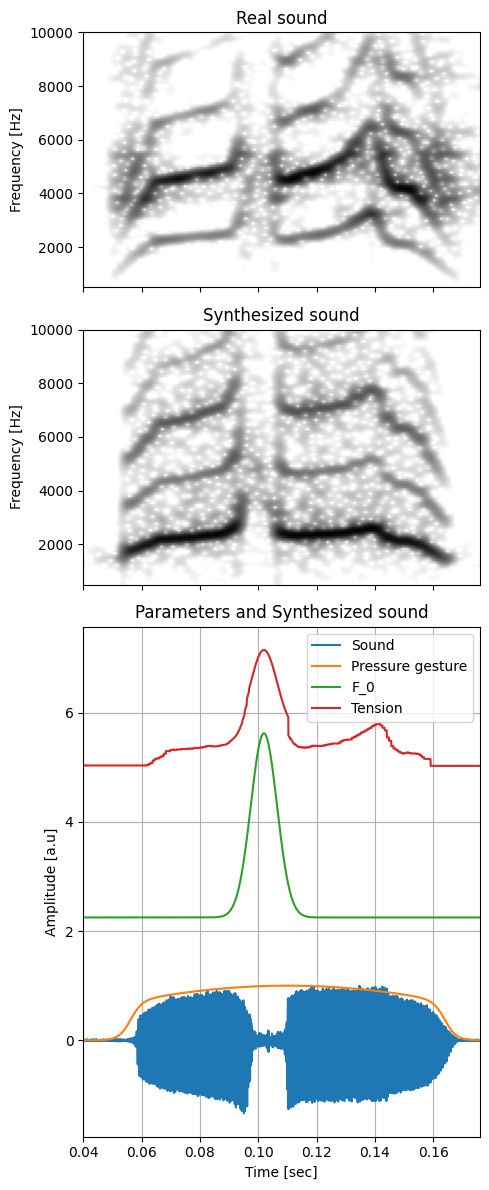

In [35]:
#Figuras silaba a silaba

# Crear subgráficos
fig, ax = plt.subplots(
    3, 1, figsize=(5, 12), sharex=True,
    gridspec_kw={'height_ratios': [1, 1, 2]}
)

# Espectrograma 1 (real)
f1, t_spec1, Sxx1 = signal.spectrogram(
    sonido_filtrado, fs=44100, window=('gaussian', 64),
    nperseg=512, noverlap=510, scaling='spectrum'
)
Sxx1 = np.clip(Sxx1, a_min=np.amax(Sxx1) / 10**5, a_max=np.amax(Sxx1))
extent1 = [tiempo_comun[0], tiempo_comun[-1], f1[0], f1[-1]]
ax[1].imshow(np.log10(Sxx1), aspect='auto', origin='lower',
             extent=extent1, cmap='Greys', rasterized=True)
ax[1].set_ylim(500, 10000)
#ax[0].set_xlim(0, 0.22)
ax[1].set_ylabel('Frequency [Hz]')
ax[1].set_title('Synthesized sound')

# Espectrograma 2 (sintético)
f2, t_spec2, Sxx2 = signal.spectrogram(
    data_sonido, fs=44100, window=('gaussian', 64),
    nperseg=512, noverlap=510, scaling='spectrum'
)
Sxx2 = np.clip(Sxx2, a_min=np.amax(Sxx2) / 10**5, a_max=np.amax(Sxx2))
extent2 = [tiempo_comun[0], tiempo_comun[-1], f2[0], f2[-1]]
ax[0].imshow(np.log10(Sxx2), aspect='auto', origin='lower',
             extent=extent2, cmap='Greys', rasterized=True)
ax[0].set_ylim(500, 10000)
ax[0].set_ylabel('Frequency [Hz]')
ax[0].set_title('Real sound')

# Envolvente y parámetros
ax[2].plot(tiempo_comun, sonido, label='Sound')
ax[2].plot(tiempo_comun, beta_interp, label='Pressure gesture')
ax[2].plot(tiempo_comun, f_cero_interp / 2 + 2, label='F_0')
ax[2].plot(tiempo_comun, tension_interp + 4, label='Tension')
ax[2].set_ylabel('Amplitude [a.u]')
ax[2].set_xlabel('Time [sec]')
ax[2].set_title('Parameters and Synthesized sound')


#for t_line in tiempos_inicio_final:
 #   ax[0].axvline(x=t_line, color='red', linestyle='--', alpha=0.7, linewidth=1)
  #  ax[1].axvline(x=t_line, color='red', linestyle='--', alpha=0.7, linewidth=1)
   # ax[2].axvline(x=t_line, color='red', linestyle='--', alpha=0.7, linewidth=1)

# Limitar tiempo
ax[0].set_xlim(0.04, 0.176)

# Ajustes finales
plt.tight_layout()
ax[2].legend()
plt.grid(True)
plt.savefig("/home/felipe/Documents/Proyectos doctorado/horneros/figuras_sintesis/espect_param_19", format='pdf', dpi=300)

plt.show()

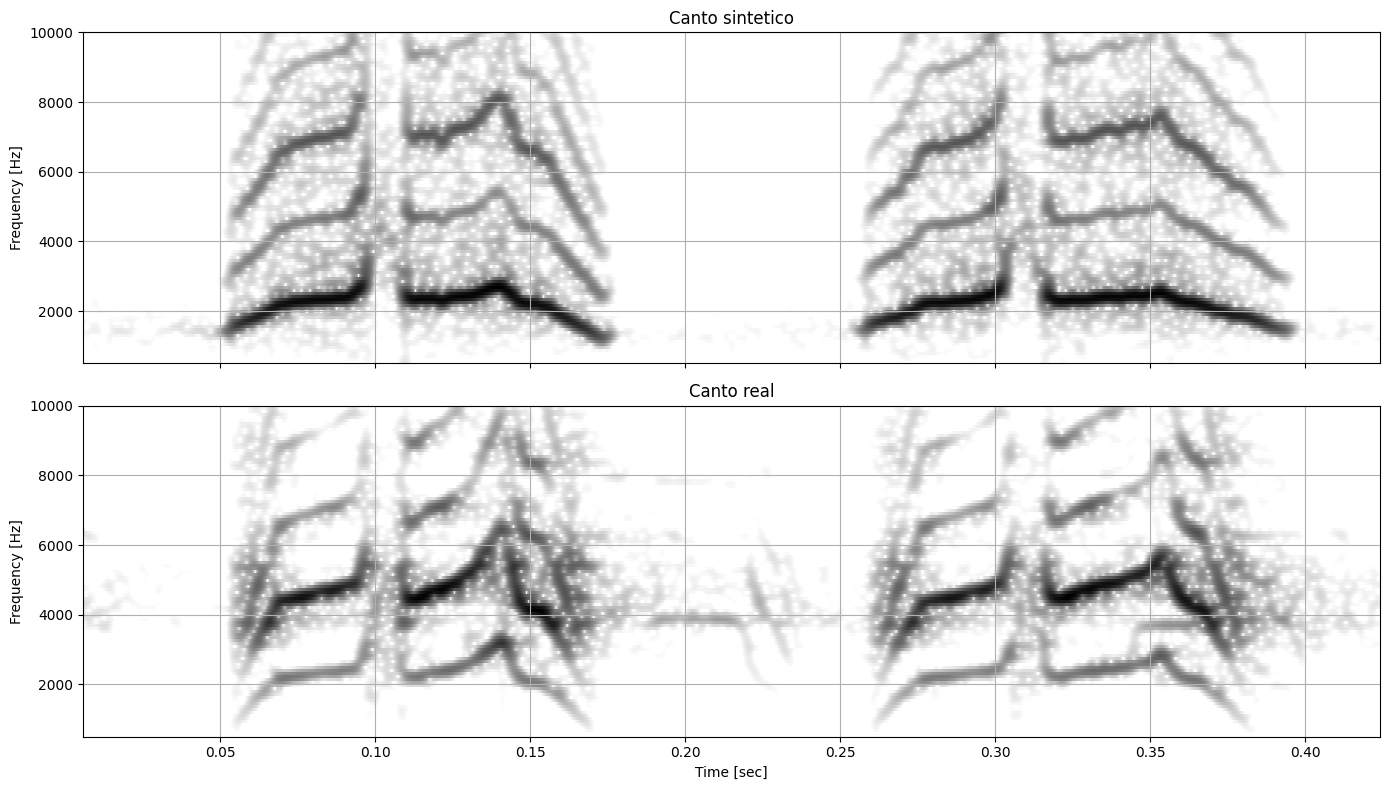

In [11]:
#####################################################
# ESPECTROGRAMA
#####################################################

sonido=np.asarray(sonido)
sonido_filtrado= sonido #senal_filtrada #sonido #senal_filtrada
#sonido=np.asarray(sonido)
sonido=sonido/max(sonido)
# Crear subgráficos: 2 filas, 1 columna, y compartir el eje X
fig, ax = plt.subplots(2, 1, figsize=(14, 8), sharex=True)  # Compartir eje X

# Espectrograma 1
f, t, Sxx = signal.spectrogram(sonido_filtrado, fs=44100, window=('gaussian', 64), nperseg=512, noverlap=510, scaling='spectrum')
Sxx = np.clip(Sxx, a_min=np.amax(Sxx) / 10**5, a_max=np.amax(Sxx))
ax[0].pcolormesh(t, f, np.log10(Sxx), rasterized=True, cmap=plt.get_cmap('Greys'))
ax[0].set_ylim(500, 10000)
#ax[0].set_xlim(0, 0.45)
ax[0].set_ylabel('Frequency [Hz]')
ax[0].set_title('Canto sintetico')
ax[0].grid(True)

# Espectrograma 2
f, t, Sxx = signal.spectrogram(data_sonido, fs=44100, window=('gaussian', 64), nperseg=512, noverlap=510, scaling='spectrum')
Sxx = np.clip(Sxx, a_min=np.amax(Sxx) / 10**5, a_max=np.amax(Sxx))
ax[1].pcolormesh(t, f, np.log10(Sxx), rasterized=True, cmap=plt.get_cmap('Greys'))
ax[1].set_ylim(500, 10000)
ax[1].set_xlabel('Time [sec]')
ax[1].set_ylabel('Frequency [Hz]')
ax[1].set_title('Canto real')

# Ajustar el layout para evitar superposiciones
plt.savefig("/home/felipe/Documents/Proyectos doctorado/horneros/figuras_sintesis/espectograma_19", format='pdf', dpi=300)
plt.tight_layout()
plt.grid(True)
plt.show()

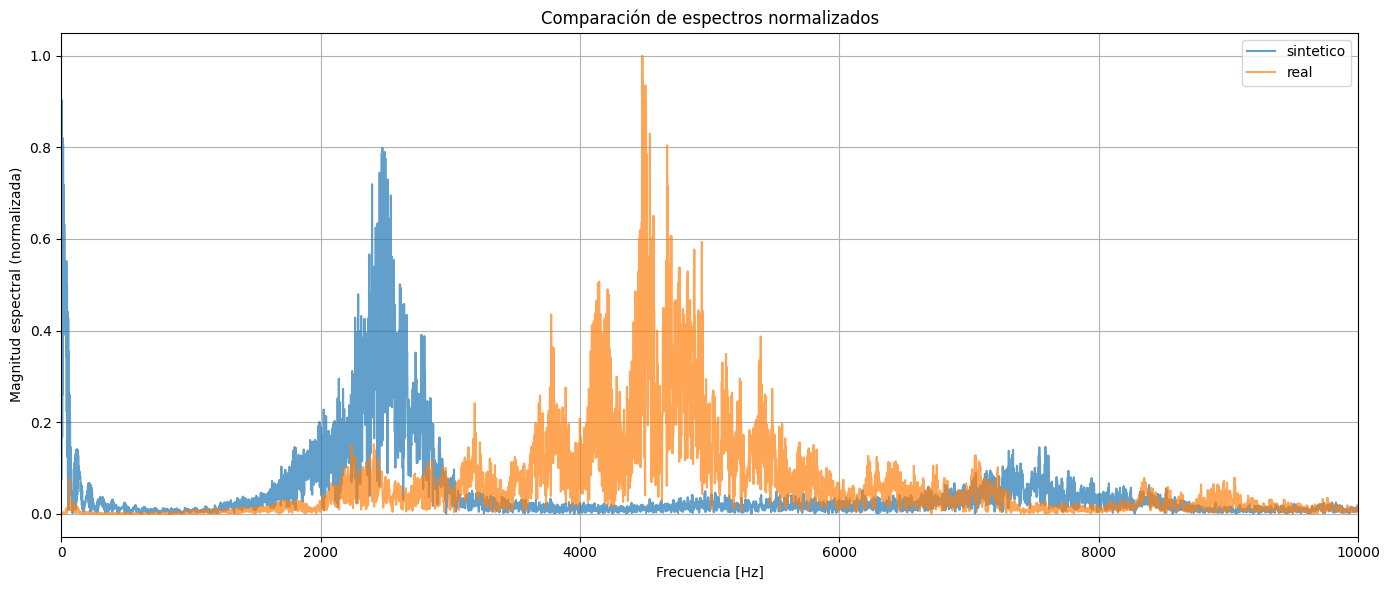

In [14]:
#####################################################
# CONTENIDO EN FRECUENCIA
#####################################################

from scipy.fft import fft, fftfreq

# Frecuencia de muestreo
fs = 44150

# --- Señal 1 ---
sonido = np.asarray(sonido)
sonido = sonido / np.max(np.abs(sonido))
n1 = len(sonido)
f1 = fftfreq(n1, 1/fs)
mask1 = f1 > 0
fft1 = np.abs(fft(sonido))
fft1 = fft1 / np.max(fft1)  # Normalizar espectro

# --- Señal 2 ---
data_sonido = np.asarray(data_sonido)
data_sonido = data_sonido / np.max(np.abs(data_sonido))
n2 = len(data_sonido)
f2 = fftfreq(n2, 1/fs)
mask2 = f2 > 0
fft2 = np.abs(fft(data_sonido))
fft2 = fft2 / np.max(fft2)  # Normalizar espectro

# --- Plot ---
plt.figure(figsize=(14, 6))
plt.plot(f1[mask1], fft1[mask1], label='sintetico', alpha=0.7)
plt.plot(f2[mask2], fft2[mask2], label='real', alpha=0.7)
plt.xlim(0, 10000)
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud espectral (normalizada)')
plt.title('Comparación de espectros normalizados')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



/tmp/ipykernel_102569/1794182165.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_s = pd.read_csv('/home/felipe/Documents/Proyectos doctorado/horneros/audios/audios_sintesis/pitch_sintesis_19.txt', sep="   ", header=None, names=["time", "f0"], skiprows=1)  # DataFrame original


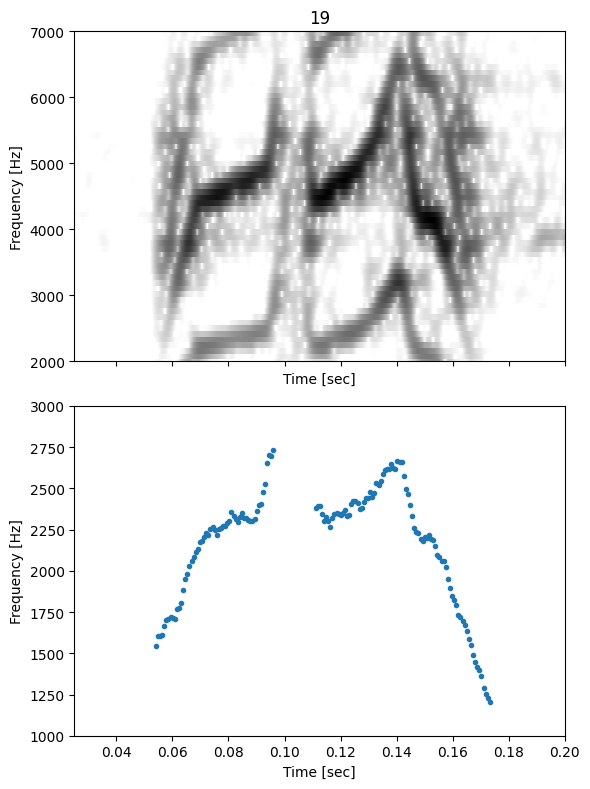

In [27]:
########################
# FIGURA PAPER
#######################

# Leer el archivo .txt
df_s = pd.read_csv('/home/felipe/Documents/Proyectos doctorado/horneros/audios/audios_sintesis/pitch_sintesis_19.txt', sep="   ", header=None, names=["time", "f0"], skiprows=1)  # DataFrame original
# info.txt es a

# Filtrar los datos (creando una copia para no modificar el original)
df_filtrado = df_s.copy()
df_filtrado.loc[df_filtrado['f0'] > 3500, 'f0'] = 0  # Reemplaza f0 > 8500 por 0 en la copia

# Normalizar los datos filtrados
tiempos = df_filtrado["time"]# / np.max(df_filtrado["time"])  # Tiempo normalizado (0 a 1)
f_0 = df_filtrado["f0"] #/ np.max(df_filtrado["f0"])         # F0 normalizado (0 a 1)


fig, ax = plt.subplots(2, 1, figsize=(6, 8), sharex=True)  # Compartir eje X



f, t, Sxx = signal.spectrogram(data_sonido, fs=44100, window=('gaussian', 64), nperseg=512, noverlap=510, scaling='spectrum')
Sxx = np.clip(Sxx, a_min=np.amax(Sxx) / 10**5, a_max=np.amax(Sxx))
ax[0].pcolormesh(t, f, np.log10(Sxx), rasterized=True, cmap=plt.get_cmap('Greys'))
ax[0].set_ylim(2000, 7000)
ax[0].set_xlim(0.025, 0.2)
ax[0].set_xlabel('Time [sec]')
ax[0].set_ylabel('Frequency [Hz]')
ax[0].set_title('19')

ax[1].plot(tiempos, f_0, 'o', markersize=3, label="F0 filtrado y normalizado")
ax[1].set_ylim(1000, 3000)
ax[1].set_xlabel('Time [sec]')
ax[1].set_ylabel('Frequency [Hz]')
ax[1].set_title('')

# Ajustar el layout para evitar superposiciones
plt.tight_layout() #para evitar superposiciones
plt.savefig("/home/felipe/Documents/Proyectos doctorado/horneros/figuras_sintesis/espectro_chico_19", format='pdf', dpi=300)

plt.show()

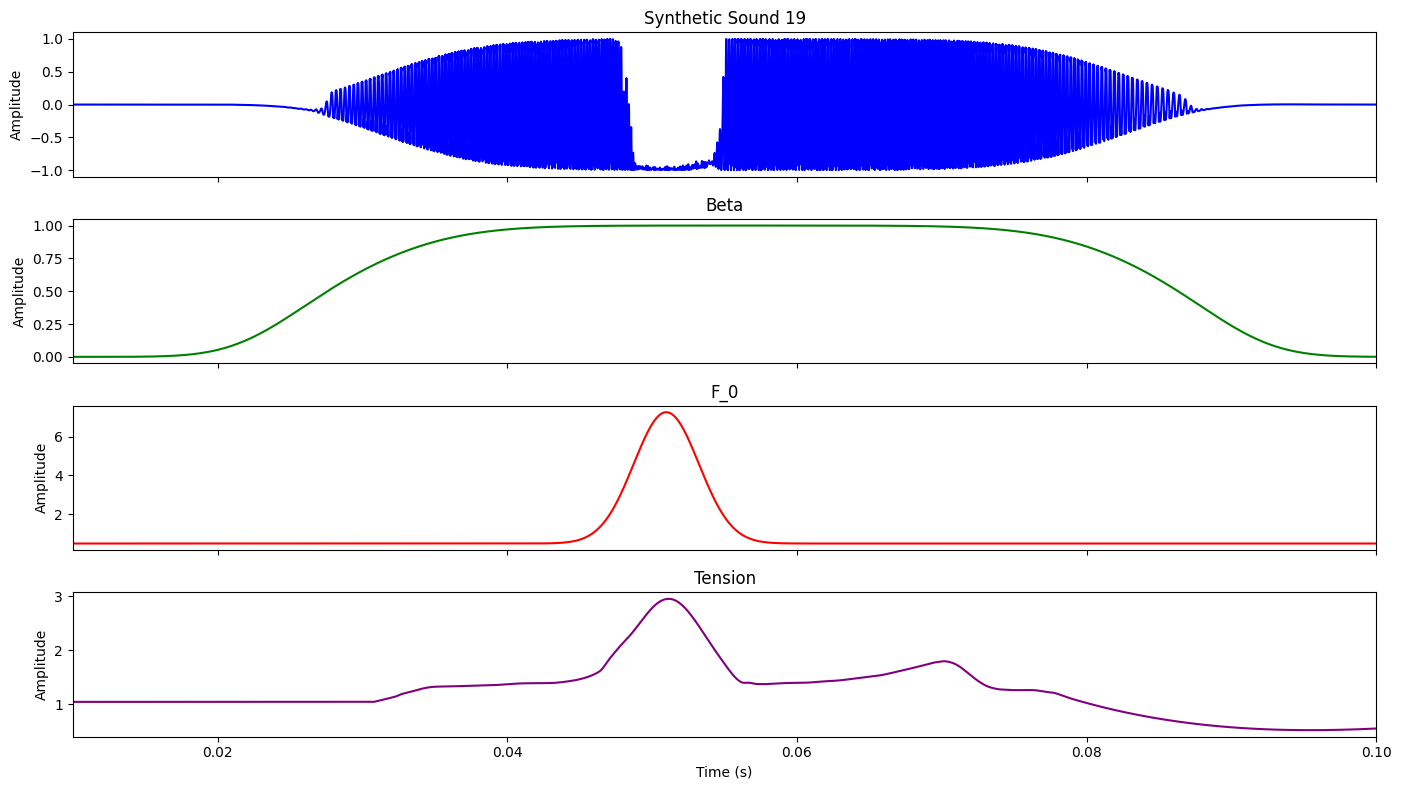

In [21]:
########################
# FIGURA PAPER
#######################

# Crear la figura con subplots verticales (4 filas, 1 columna)
fig, axs = plt.subplots(4, 1, figsize=(14, 8), sharex=True)

# Configurar espaciado entre subplots
plt.subplots_adjust(hspace=0.3)

# Subplot 1: sonido
axs[0].plot(tiempos[:50000], sonido[:50000], 'b-')
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Synthetic Sound 19')

# Subplot 2: beta
axs[1].plot(tiempos[:50000], beta[:50000], 'g-')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('Beta')

# Subplot 3: f_cero
axs[2].plot(tiempos[:50000], f_cero[:50000], 'r-')
axs[2].set_ylabel('Amplitude')
axs[2].set_title('F_0')

# Subplot 4: tension
axs[3].plot(tiempos[:50000], tension[:50000], 'purple')
axs[3].set_ylabel('Amplitude')
axs[3].set_title('Tension')
axs[3].set_xlim(0.01, 0.1)
# Configurar etiqueta x solo en el subplot inferior
axs[3].set_xlabel('Time (s)')

# Ajustar la disposición para optimizar espacio
plt.tight_layout()

# Mostrar la figura
plt.show()

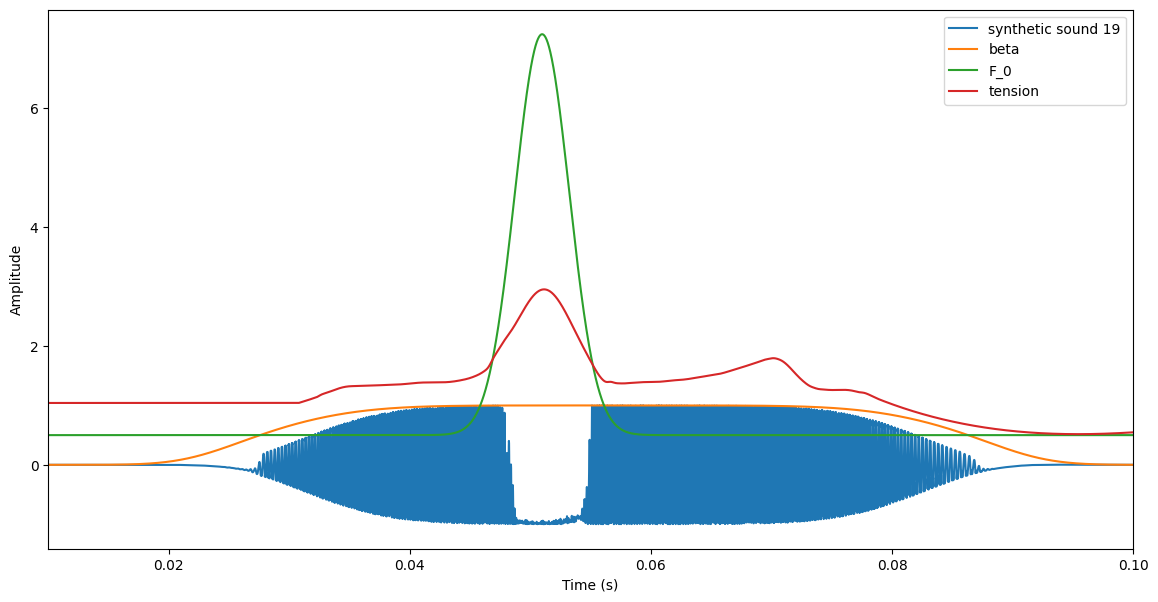

In [25]:
#####################################################
# GRAFICAMOS
#####################################################

plt.figure(figsize=(14,7))
sonido = np.asarray(sonido)/np.max(np.asarray(sonido))
plt.plot(tiempo1,sonido, label='synthetic sound 19')
plt.plot(tiempo1,beta, label='beta')
plt.plot(tiempo1,f_cero, label='F_0')
plt.plot(tiempo1, tension, label='tension')
plt.xlim(0.01, 0.1)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
#plt.plot(tiempo1[:10000],actividad[:10000])
#plt.plot(tiempo1,inestabilidad)

Duración audio: 0.430 segundos
Duración parámetros: 0.215 segundos


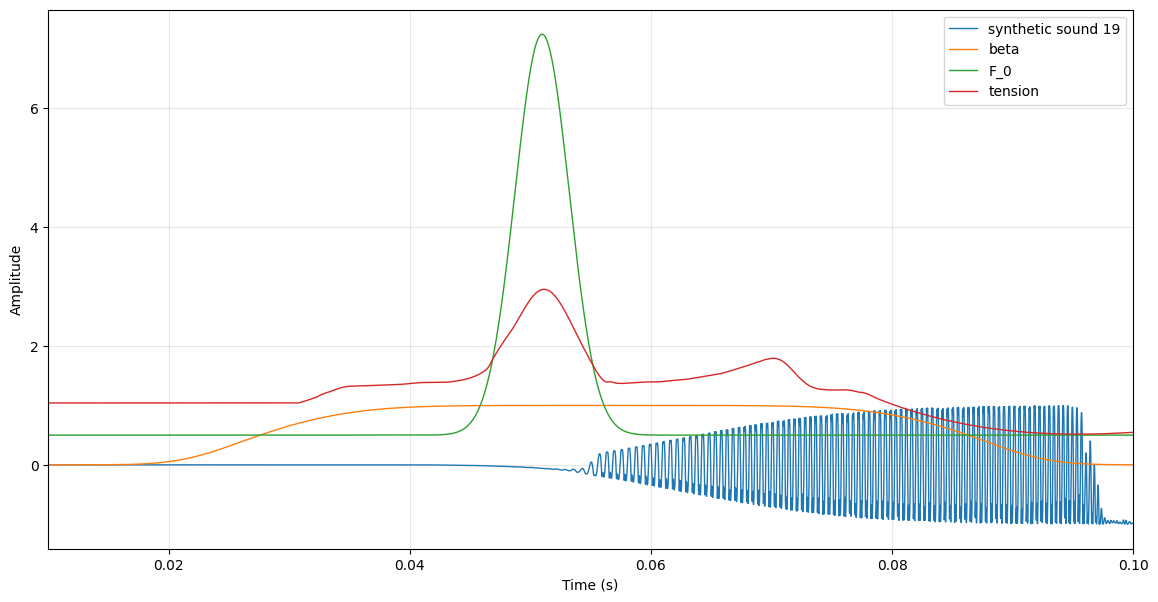

"\n# Submuestrear parámetros cada 2 puntos\nbeta_sub = beta[::2]\nf_cero_sub = f_cero[::2]\ntension_sub = tension[::2]\n\n# Crear eje temporal común\ntiempo_comun = np.arange(min(len(sonido), len(beta_sub))) / 44100\n\nplt.figure(figsize=(14,7))\nsonido_norm = np.asarray(sonido) / np.max(np.asarray(sonido))\n\nplt.plot(tiempo_comun, sonido_norm[:len(tiempo_comun)], label='synthetic sound 19', linewidth=1)\nplt.plot(tiempo_comun, beta_sub[:len(tiempo_comun)], label='beta', linewidth=1)\nplt.plot(tiempo_comun, f_cero_sub[:len(tiempo_comun)], label='F_0', linewidth=1)\nplt.plot(tiempo_comun, tension_sub[:len(tiempo_comun)], label='tension', linewidth=1)\n\nplt.xlim(0.01, 0.1)\nplt.xlabel('Time (s)')\nplt.ylabel('Amplitude')\nplt.legend()\nplt.grid(True, alpha=0.3)\nplt.show()\n"

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Crear los ejes temporales correctos
# Para el sonido (muestreado a 44100 Hz)
tiempo_audio = np.arange(len(sonido)) / 44100

# Para los parámetros (calculados con dt = 1/(2*44100))
tiempo_parametros = np.arange(len(beta)) / (2 * 44100)

# Verificar que las duraciones sean consistentes
print(f"Duración audio: {tiempo_audio[-1]:.3f} segundos")
print(f"Duración parámetros: {tiempo_parametros[-1]:.3f} segundos")

plt.figure(figsize=(14,7))

# Normalizar el sonido
sonido_norm = np.asarray(sonido) / np.max(np.asarray(sonido))

# Graficar cada señal con su eje temporal correcto
plt.plot(tiempo_audio, sonido_norm, label='synthetic sound 19', linewidth=1)
plt.plot(tiempo_parametros, beta, label='beta', linewidth=1)
plt.plot(tiempo_parametros, f_cero, label='F_0', linewidth=1)
plt.plot(tiempo_parametros, tension, label='tension', linewidth=1)

plt.xlim(0.01, 0.1)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Opción alternativa: Si quieres que todos tengan la misma resolución
# (submuestreando los parámetros para igualar al audio)
"""
# Submuestrear parámetros cada 2 puntos
beta_sub = beta[::2]
f_cero_sub = f_cero[::2]
tension_sub = tension[::2]

# Crear eje temporal común
tiempo_comun = np.arange(min(len(sonido), len(beta_sub))) / 44100

plt.figure(figsize=(14,7))
sonido_norm = np.asarray(sonido) / np.max(np.asarray(sonido))

plt.plot(tiempo_comun, sonido_norm[:len(tiempo_comun)], label='synthetic sound 19', linewidth=1)
plt.plot(tiempo_comun, beta_sub[:len(tiempo_comun)], label='beta', linewidth=1)
plt.plot(tiempo_comun, f_cero_sub[:len(tiempo_comun)], label='F_0', linewidth=1)
plt.plot(tiempo_comun, tension_sub[:len(tiempo_comun)], label='tension', linewidth=1)

plt.xlim(0.01, 0.1)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
"""